In [1]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn
from torch.utils.data import DataLoader

from datasets import Dataset
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier

import plotly.graph_objects as go

from multiprocessing.pool import ThreadPool
from threading import Lock

PATH = "./data/"
device = "cuda:0"

##### text preprocessing

In [2]:
"""Tokenization classes for Italian AlBERTo models."""
import collections
import os

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens

    unpack_hashtags=True,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

a = AlBERTo_Preprocessing(do_lower_case=True)
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)
print(b)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
<hashtag> il governo </hashtag> presenta le linee guida sulla scuola <hashtag> la buona scuola </hashtag> <url>


##### pretrained tokenizer and AlBERTo

In [3]:
from transformers import AutoTokenizer, AutoModel

def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

a = AlBERTo_Preprocessing(do_lower_case=True)
s: str = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)

tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = 128 #model.config.max_position_embeddings
tokens = tok.tokenize(b)
print(tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


##### models

In [4]:
class MyNetMC(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMC, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
class MyNetMCTuned(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer without Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMCTuned, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)
        self.linear = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        logits = self.linear(outputs[1])
        loss = self.loss_fct(logits, labels)
        return logits , loss

#### EvSent

In [5]:
def evSent(string):
    url = "http://ai-rest.blupixelit.eu/rest.php?action=SentiLex&username=asr&password=asrpwd&lang=it&text=%s"%string
    try:
        result = requests.get(url).text
    except requests.exceptions.RequestException as e:
        raise print("ERROR EVSENT")
    result = (re.findall("<sentiment>(.*?)</sentiment>", result)[0])
    if result == "positive":
        return 2
    elif result == "negative":
        return 0
    else:
        return 1

def worker(label, text, pbar, preds, true, lock):
    res = evSent(text)
    lock.acquire()
    global index
    preds[index] = res
    true[index] = label
    index += 1
    pbar.update(1)
    lock.release()

def evsent_remove_neutrals(true, preds):
    preds2 , true2 = [] , []
    for i in range(len(preds)):
        if true[i] == 1:
            continue
        elif true[i] == 2:
            true2.append(1)
        else:
            true2.append(0)
        if preds[i] == 1:
            preds2.append(0 if np.random.rand(1) > 0.50 else 1)
        elif preds[i] == 2:
            preds2.append(1)
        else:
            preds2.append(0) 
    print(classification_report(true2, preds2, target_names=["negative", "positive"]))

#####  utility functions

In [6]:
def validation_epoch(model, epoch, val_loader, kind, logging):
    model.eval()
    targets , outputs , logitss = [] , [] , []
    cumulative_loss = 0.
    with torch.no_grad():
        for i , data in enumerate(val_loader, 0):
            batch = {k: v.to(device) for k, v in data.items()}
            logits , loss = model(**batch)
            if kind != "test": cumulative_loss += loss.detach()
            if (i+1) % 25 == 0 and logging:
                print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
            
            targets.extend(batch["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())
    if logging: wandb.log({kind: {'loss': cumulative_loss.item() / len(outputs)}})
    return outputs, targets, logitss


def eval_feelit_model(dataset, keep_neutrals, dataset_name, plot_confidence=False):
    tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
    tok_feelit.model_max_length = 128

    model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
    model.eval()

    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    else:
        testing = Dataset.from_pandas(dataset)\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 1)\
                .filter(lambda example: example['labels'] != 3)\
                .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_loader = DataLoader(testing, batch_size=64)

    trues , preds , logitss = [] , [] , []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
            logits = model(**batch)[0]
            trues.extend(data["labels"].detach().numpy())
            preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())

    proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
    assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
    for i in range(len(proba)):
        if keep_neutrals:
            if preds[i] == 1: 
                preds[i] = 2
            if max(proba[i,0] , proba[i, 1]) <= 0.55: #set to neutral  if the prediction's confidence is too low
                preds[i] = 1
        else:
            if trues[i] == 2: #the net produces just [0,1] for positive/negative, so adjust label
                trues[i] = 1

    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))
    cm = confusion_matrix(trues, preds, normalize='all')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets).plot()
    tmp = "no neutral" if not keep_neutrals else ""
    plt.title(f"{dataset_name} {tmp} - Feel-it pretrained")

    if plot_confidence:
        trues = np.array(trues)
        preds = np.array(preds)
        #plot_confidence_distribution(trues, preds, proba, name="Feel-it model", dataset="SENTIPOLC no neutral", plot_neutral=False, adjust_positive=True)
        
        
def train_epoch(model, train_loader, optimizer, scheduler, epoch, logging):
    model.train()
    targets , outputs = [] , []
    cumulative_loss = 0.
    for i , data in enumerate(train_loader, 0): 
        targets.extend(data["labels"].numpy())
        
        batch = {k: v.to(device) for k, v in data.items()}
        logits , loss = model(**batch)

        cumulative_loss += loss.detach()
        if (i+1) % 25 == 0 and logging:
            print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
    return outputs, targets

def fine_tune(train_loader, model, logging, model_type, dataset_val=None):
    if model_type == "opt":
        hyper = {'learning_rate': 3.000003529363845e-06, 'warmup_steps': 0.6, 'weight_decay': 0.000260393798851559}
    elif model_type == "MC":
        hyper = {'learning_rate': 2e-5, 'warmup_steps': 0.1, 'weight_decay': 0.1}
        
    optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyper["learning_rate"],
                              weight_decay=hyper["weight_decay"], 
                              eps=1e-6)
    num_epochs = 3
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    num_warmup_steps =  int(num_train_steps * hyper["warmup_steps"])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
    
    for epoch in range(num_epochs):
        outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
        #outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging=False)
        #f1_val = f1_score(targets, outputs, average='macro')
        #if f1_val > best_value:
        #    best_value = f1_val
        #    torch.save(model.state_dict(), "data/models/alberto_multiclass_tuned.pt")    
        #if early_stopping.on_epoch_end(epoch, f1_val):
        #    print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        #    break

        if logging: 
            f1_train = f1_score(targets, outputs, average='macro')
            print(f"Train F1 = {f1_train}")
    return model
        

def eval_alberto(model, model_name, model_params, dataset, dataset_name, keep_neutrals, plot_confidence, return_preds=False, fine_tuning=False, dataset_train=None, logging=False, model_type=None):
    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(tokenize_function, batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    else:
        testing = Dataset.from_pandas(dataset)\
                    .filter(lambda example: example['labels'] != 1)\
                    .filter(lambda example: example['labels'] != 3)\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    test_loader = DataLoader(testing, batch_size=64)

    model = model(3).to(device)
    model.load_state_dict(torch.load(PATH + model_params))
    
    if fine_tuning:
        if keep_neutrals:
            training = Dataset.from_pandas(dataset_train)\
                            .filter(lambda example: example['labels'] != 3)\
                            .map(tokenize_function, batched=True)\
                            .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
        else:
            training = Dataset.from_pandas(dataset_train)\
                        .filter(lambda example: example['labels'] != 1)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(tokenize_function, batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
        train_loader = DataLoader(training, batch_size=64, shuffle=True)
        model = fine_tune(train_loader, model, logging, model_type)

    preds , trues , logitss = validation_epoch(model, None, test_loader, "test", logging=False)
    for i in range(len(preds)):
        if not keep_neutrals:
            if trues[i] == 2: 
                 trues[i] = 1
            if preds[i] == 1:
                idx = np.argmax([logitss[i][0], logitss[i][2]])
                assert logitss[i][idx] > logitss[i][0 if idx == 1 else 2]
                preds[i] = idx
            elif preds[i] == 2:
                preds[i] = 1
#             if preds[i] == 1:
#                 preds2.append(0 if np.random.rand(1) > 0.50 else 1)
#             elif preds[i] == 2:
#                 preds2.append(1)
#             else:
#                 preds2.append(0) 
#             if preds[i] == 2: 
#                 preds[i] = 1
#             if trues[i] == 2: 
#                 trues[i] = 1
                
    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues, preds, normalize='all'), display_labels=targets).plot()
    tmp = "no neutrals" if not keep_neutrals else ""
    plt.title(f"{dataset_name} - {model_name} {tmp}")
    
    proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
    trues = np.array(trues)
    preds = np.array(preds)
        
    if plot_confidence:
        plot_confidence_distribution(trues, preds, proba, name=model_name, dataset=dataset_name, plot_neutral=True)
    if return_preds:
        return preds, trues, proba
    
    
def eval_mfc_baseline(dataset_train, dataset_test, keep_neutrals):
    dummy_clf = DummyClassifier(strategy="stratified").fit(dataset_train.text, dataset_train.labels)
    preds = dummy_clf.predict(dataset_test.text)
    
    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(dataset_test.labels, preds, target_names=targets))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(dataset_test.labels, preds, normalize='all'), display_labels=targets).plot()

In [7]:
def plot_confidence_distribution(trues, preds, proba, name, dataset, plot_neutral, adjust_positive=False):
    false_negatives = np.logical_and(trues != 0, preds == 0)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_negatives, np.argmax(proba[false_negatives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        autosize=False,
        width=600,
        height=300,
        title=f"{name}'s confidence distribution for {dataset} - false negatives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()

    if plot_neutral:
        false_neutrals = np.logical_and(trues != 1, preds == 1)
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=proba[false_neutrals, np.argmax(proba[false_neutrals,:], axis=1)], 
                                   xbins=dict(
                                    start=0.,
                                    end=1.0,
                                    size=0.1
                                    ), 
                                   histnorm='probability'))
        fig.update_layout(
            autosize=False,
            width=600,
            height=300,
            title=f"{name}'s confidence distribution for {dataset} - false neutrals",
            xaxis_title="confidence",
            yaxis_title="normalized count",
        )
        fig.update_xaxes(range=[0., 1.])
        fig.show()

    false_positives = np.logical_and(trues != 2, preds == 2) if not adjust_positive else np.logical_and(trues != 1, preds == 1)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_positives, np.argmax(proba[false_positives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        autosize=False,
        width=600,
        height=300,
        title=f"{name}'s confidence distribution for {dataset} - false positives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()
    
    
def get_lexicon(dataset):
    """
    Takes as input an array containing tokenized text
    """
    return set([token for sentence in dataset for token in tok.tokenize(sentence)])

# SENTIPOLC16

In [8]:
train_sentipolc = pd.read_csv(PATH + "Sentipolc16/training_set_sentipolc16.csv")

In [9]:
file1 = open(PATH + "Sentipolc16/test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test_sentipolc = []
for line in Lines:
  arr = line.split("\",")
  if len(arr) != 9:
    arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
    del arr[9:]
  for i in range(8):
    arr[i] = int(arr[i].strip("\""))
  test_sentipolc.append(arr)

test_sentipolc = pd.DataFrame(test_sentipolc, columns=train_sentipolc.columns)
test_sentipolc.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,"""Tra 5 minuti presentazione piano scuola del g..."
1,507075789456961536,1,1,0,0,1,0,2,"""\""@matteorenzi: Alle 10 appuntamento su http:..."
2,507077511902425088,1,0,1,0,0,1,2,"""#labuonascuola gli #evangelisti #digitali non..."
3,507079183315787777,0,0,0,0,0,0,2,"""Riforma scuola Tutto il discorso di Renzi su..."
4,507080190225563648,1,0,0,0,0,0,2,""".@matteorenzi @MiurSocial #labuonascuola bast..."


In [10]:
def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed    -> 3
    """
    if row["opos"] == 0 and row["oneg"] == 0:
        return 1
    elif row["oneg"] == 0 and row["opos"] == 1:
        return 2
    elif row["oneg"] == 1 and row["opos"] == 0:
        return 0
    else:
        return 3

tmp = pd.DataFrame({"text": train_sentipolc.text.apply(a.preprocess), "idx": train_sentipolc.index, "labels": train_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset_sentipolc = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
print("train: ", len(tmp[tmp.labels != 3]), np.unique(tmp[tmp.labels != 3].labels, return_counts=True)[1]/len(tmp[tmp.labels != 3]))
print("Test: ", len(dataset_sentipolc[dataset_sentipolc.labels != 3]), np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels, return_counts=True)[1]/len(dataset_sentipolc[dataset_sentipolc.labels != 3]))
lexicon_sentipolc = get_lexicon(dataset_sentipolc.text)

train:  6970 [0.36484935 0.40401722 0.23113343]
Test:  1964 [0.37372709 0.46537678 0.16089613]


### Baseline


              precision    recall  f1-score   support

    negative       0.60      0.15      0.23       734
     neutral       0.51      0.24      0.33       914
    positive       0.17      0.72      0.27       316

    accuracy                           0.28      1964
   macro avg       0.43      0.37      0.28      1964
weighted avg       0.49      0.28      0.28      1964



 No neutrals

              precision    recall  f1-score   support

    negative       0.79      0.24      0.37       734
    positive       0.33      0.85      0.47       316

    accuracy                           0.43      1050
   macro avg       0.56      0.55      0.42      1050
weighted avg       0.65      0.43      0.40      1050



 SMFC

              precision    recall  f1-score   support

    negative       0.38      0.36      0.37       734
     neutral       0.46      0.40      0.43       914
    positive       0.18      0.27      0.22       316

    accuracy                           0.36     

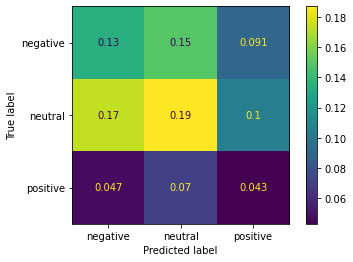

In [14]:
#%%script echo skipping
examples = dataset_sentipolc[dataset_sentipolc.labels != 3] # exclude mixed tweets

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=6)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)


##
# Stochastic MFC
##
print("\n\n SMFC\n")
eval_mfc_baseline(tmp[tmp.labels != 3], dataset_sentipolc[dataset_sentipolc.labels != 3], keep_neutrals=True)

### AlBERTo pretrained - SENTIPOLC16



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964



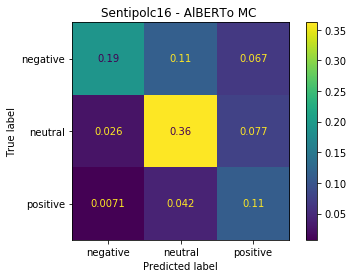

In [18]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_sentipolc, "Sentipolc16", keep_neutrals=True, plot_confidence=True)

### AlBERTo opt - SENTIPOLC16



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.85      0.55      0.67       734
     neutral       0.70      0.85      0.76       914
    positive       0.53      0.63      0.58       316

    accuracy                           0.70      1964
   macro avg       0.69      0.68      0.67      1964
weighted avg       0.73      0.70      0.70      1964



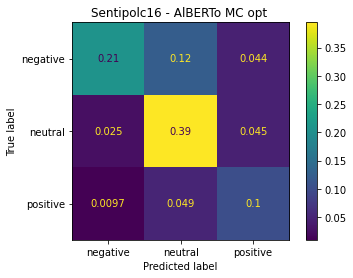

In [13]:
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_sentipolc, "Sentipolc16", keep_neutrals=True, plot_confidence=True)

### Feel-it model - SENTIPOLC16
Note that it was trained just for positive/negative class, so the neutral class is taken for examples with low confidence in the prediction.


              precision    recall  f1-score   support

    negative       0.60      0.89      0.72       734
     neutral       0.33      0.00      0.00       914
    positive       0.29      0.80      0.42       316

    accuracy                           0.46      1964
   macro avg       0.41      0.56      0.38      1964
weighted avg       0.43      0.46      0.34      1964




              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       734
    positive       0.76      0.80      0.78       316

    accuracy                           0.86      1050
   macro avg       0.83      0.85      0.84      1050
weighted avg       0.87      0.86      0.86      1050



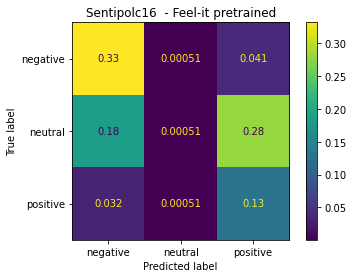

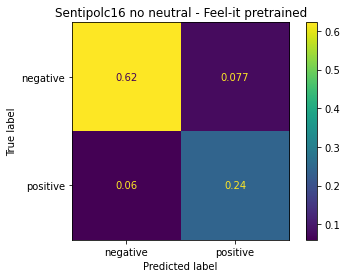

In [20]:
dataset = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
eval_feelit_model(dataset, keep_neutrals=True, dataset_name="Sentipolc16", plot_confidence=False)
eval_feelit_model(dataset, keep_neutrals=False, dataset_name="Sentipolc16", plot_confidence=False)

# FEEL-IT dataset

In [11]:
train_feel_it = pd.read_csv(PATH + "Feel-it/feelit.tsv", sep='\t', header=0, names=["text", "label"])
print("\nAverage tweet lenght: ", np.mean(train_feel_it["text"].apply(len)))
train_feel_it.head()


Average tweet lenght:  141.8939617083947


,text,label
0,"@USER Adoro questa canzone, è una delle mie pr...",joy
1,#MilanNovara È arrivato il 3 gol del MILAN ❤🖤...,joy
2,stream icarus falls 🖤 zayn ha un talento ed è ...,sadness
3,Persona di indiscutibile cultura #Daverio avev...,sadness
4,Oggi la direttrice @USER ha spiegato che #COVI...,fear


In [12]:
def emotion2sentiment(row):
    """
        Return a single scalar integer label associated to the emotion of the tweet.

        joy -> 2
        anger sadness fear  -> 0
    """
    if row["label"] == "joy":
        return 2
    elif row["label"] == "sadness" or row["label"] == "fear" or row["label"] == "anger":
        return 0
    else:
        raise ValueError('Value not recognized')

#train set
dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})
print("Test: ", len(dataset_feel_it), np.unique(dataset_feel_it.labels, return_counts=True)[1]/len(dataset_feel_it))
lexicon_feel_it = get_lexicon(dataset_feel_it.text)
print("Sentipolc lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_feel_it.intersection(lexicon_sentipolc))/len(lexicon_feel_it.union(lexicon_sentipolc)),2))

Token indices sequence length is longer than the specified maximum sequence length for this model (178 > 128). Running this sequence through the model will result in indexing errors


Test:  2037 [0.64261168 0.35738832]
Sentipolc lexicon  ∩ Feel-it lexicon:  0.22


### Evsent baseline

In [39]:
#%%script echo skipping
examples = dataset_feel_it

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)


              precision    recall  f1-score   support

    negative       0.89      0.33      0.48      1309
     neutral       0.00      0.00      0.00         0
    positive       0.52      0.41      0.46       728

    accuracy                           0.36      2037
   macro avg       0.47      0.24      0.31      2037
weighted avg       0.76      0.36      0.47      2037



 No neutrals

              precision    recall  f1-score   support

    negative       0.74      0.58      0.65      1309
    positive       0.46      0.64      0.54       728

    accuracy                           0.60      2037
   macro avg       0.60      0.61      0.59      2037
weighted avg       0.64      0.60      0.61      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### AlBERTo pretrained - FEEL-IT
Recall that FEEL_IT does not have neutral tweets, but AlBERTo was trained with such class



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.95      0.83      0.89      1309
     neutral       0.00      0.00      0.00         0
    positive       0.83      0.82      0.83       728

    accuracy                           0.83      2037
   macro avg       0.59      0.55      0.57      2037
weighted avg       0.91      0.83      0.87      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



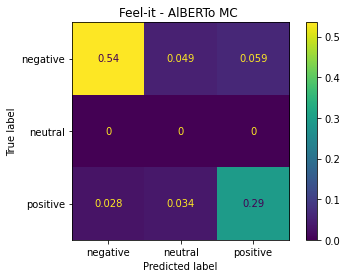

In [25]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_feel_it, "Feel-it", keep_neutrals=True, plot_confidence=False)

### AlBERTo opt - Feel-IT



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.94      0.84      0.88      1309
     neutral       0.00      0.00      0.00         0
    positive       0.82      0.84      0.83       728

    accuracy                           0.84      2037
   macro avg       0.59      0.56      0.57      2037
weighted avg       0.90      0.84      0.86      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


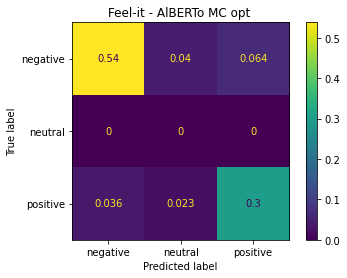

In [17]:
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_feel_it, "Feel-it", keep_neutrals=True, plot_confidence=False)

### FEEL_IT model - FEEL_IT dataset


              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      1309
    positive       0.97      0.99      0.98       728

    accuracy                           0.99      2037
   macro avg       0.98      0.99      0.99      2037
weighted avg       0.99      0.99      0.99      2037



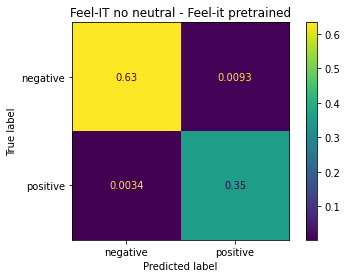

In [27]:
dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})
eval_feelit_model(dataset_feel_it, keep_neutrals=False, dataset_name="Feel-IT", plot_confidence=False)

# Amazon reviews

In [17]:
##
# To split the dataset, one split, read the directly the 2 files
##

# amazon = pd.read_json(PATH + "Amazon-reviews/Amazon_reviews_computer_cloths_food_shoaps.json")
# X_train, X_test = train_test_split(amazon, test_size=0.3, random_state=42, stratify=amazon["rating"])
# X_train.to_json(PATH + "Amazon-reviews/amazon_train.json")
# X_test.to_json(PATH + "Amazon-reviews/amazon_test.json")

In [13]:
amazon_train = pd.read_json(PATH + "Amazon-reviews/amazon_train.json")
amazon_test = pd.read_json(PATH + "Amazon-reviews/amazon_test.json")

amazon_train["text"] = amazon_train["title"] + ": " +  amazon_train["text"]
amazon_test["text"] = amazon_test["title"] + ": " +  amazon_test["text"]

print("Train: ", len(amazon_train) , np.unique(amazon_train.rating, return_counts=True)[1]/len(amazon_train))
print("Test:", len(amazon_test) , np.unique(amazon_test.rating, return_counts=True)[1]/len(amazon_test))

print("\nAverage review lenght Train: ", np.mean(amazon_train["text"].apply(len)))
print("\nAverage review lenght Test: ", np.mean(amazon_test["text"].apply(len)))

amazon_test.head()

Train:  820 [0.15       0.06585366 0.10731707 0.16707317 0.5097561 ]
Test: 352 [0.14772727 0.06534091 0.10795455 0.16761364 0.51136364]

Average review lenght Train:  462.36341463414635

Average review lenght Test:  406.3011363636364


,title,text,rating
136,Inutile.,Inutile.: Purtroppo non funziona,1
707,Soddisfatta,"Soddisfatta: Spedizione veloce, arrivata in an...",5
233,Si è fuso subito,"Si è fuso subito: bello, ha tutto, mandrino au...",3
272,Mi ha cambiato la vita,Mi ha cambiato la vita: Sono un artista CGI e ...,5
1013,Non funzionante,Non funzionante: L'unica funzione che ha è que...,1


In [14]:
amazon_test[amazon_test.text.str.contains("Preso durante")].iloc[0].text

"perplesso: Preso durante un'offerta a tempo a circa 50 euro.  Se l'avessi pagato a prezzo pieno l'avrei restituito. Il trapano funziona abbastanza bene,ma dopo due (DUE!!!) fori nel cemento armato, il motore era rovente. Dalla linea blu della Bosch (quindi Professional) mi sarei aspettato prestazioni migliori. Se vi serve un trapano per uso hobbistico, cecate altri prodotti sicuramente più economici"

In [15]:
def rating2sentiment(row):
    """
        Returns the polarity depending on the rating of the review
    """
    if row["rating"] == 3:
        return 1
    elif row["rating"] > 3:
        return 2
    elif row["rating"] < 3:
        return 0
    
#tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
#tok.model_max_length = 400

dataset_amazon_train = pd.DataFrame({"text": amazon_train.text.apply(a.preprocess), "idx": amazon_train.index, "labels": amazon_train[["rating"]].apply(rating2sentiment, axis=1)}) 
dataset_amazon_test = pd.DataFrame({"text": amazon_test.text.apply(a.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)}) 
print("Train: ", len(dataset_amazon_train), np.unique(dataset_amazon_train.labels, return_counts=True)[1]/len(dataset_amazon_train))
print("Test: ", len(dataset_amazon_test), np.unique(dataset_amazon_test.labels, return_counts=True)[1]/len(dataset_amazon_test))
lexicon_amazon = get_lexicon(dataset_amazon_test.text)
print("Amazon lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_amazon.intersection(lexicon_feel_it))/len(lexicon_amazon.union(lexicon_feel_it)),2))
print("Amazon lexicon  ∩ Sentipolc lexicon: ", round(len(lexicon_amazon.intersection(lexicon_sentipolc))/len(lexicon_amazon.union(lexicon_sentipolc)),2))

Train:  820 [0.21585366 0.10731707 0.67682927]
Test:  352 [0.21306818 0.10795455 0.67897727]
Amazon lexicon  ∩ Feel-it lexicon:  0.17
Amazon lexicon  ∩ Sentipolc lexicon:  0.17


### EvSent baseline


              precision    recall  f1-score   support

    negative       0.23      0.31      0.26        75
     neutral       0.11      0.26      0.15        38
    positive       0.80      0.52      0.63       239

    accuracy                           0.45       352
   macro avg       0.38      0.36      0.35       352
weighted avg       0.60      0.45      0.50       352



 No neutrals

              precision    recall  f1-score   support

    negative       0.31      0.55      0.39        75
    positive       0.81      0.62      0.70       239

    accuracy                           0.60       314
   macro avg       0.56      0.58      0.55       314
weighted avg       0.69      0.60      0.63       314



 SMFC

              precision    recall  f1-score   support

    negative       0.17      0.15      0.16        75
     neutral       0.11      0.11      0.11        38
    positive       0.67      0.71      0.69       239

    accuracy                           0.52     

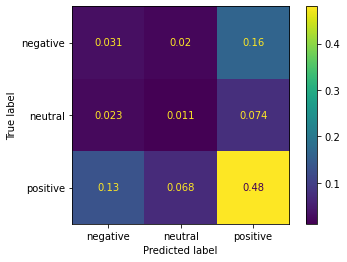

In [19]:
#%%script echo skipping
examples = dataset_amazon_test

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p= 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text[:1987], pbar, preds, true, lock)) #[:1987] to avoid too long URL
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)

##
# Stochastic MFC
##
print("\n\n SMFC\n")
eval_mfc_baseline(dataset_amazon_train, dataset_amazon_test, keep_neutrals=True)

### AlBERTo MC/opt - Amazon reviews



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.39      0.75      0.51        75
     neutral       0.08      0.11      0.09        38
    positive       0.90      0.60      0.72       239

    accuracy                           0.58       352
   macro avg       0.46      0.48      0.44       352
weighted avg       0.70      0.58      0.61       352



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.38      0.79      0.51        75
     neutral       0.17      0.11      0.13        38
    positive       0.90      0.65      0.75       239

    accuracy                           0.62       352
   macro avg       0.48      0.51      0.46       352
weighted avg       0.71      0.62      0.63       352



 AlBERTo MC no neutrals





              precision    recall  f1-score   support

    negative       0.46      0.75      0.57        75
    positive       0.90      0.72      0.80       239

    accuracy                           0.73       314
   macro avg       0.68      0.74      0.69       314
weighted avg       0.80      0.73      0.75       314



 AlBERTo MC opt no neutrals





              precision    recall  f1-score   support

    negative       0.44      0.79      0.56        75
    positive       0.91      0.69      0.78       239

    accuracy                           0.71       314
   macro avg       0.68      0.74      0.67       314
weighted avg       0.80      0.71      0.73       314



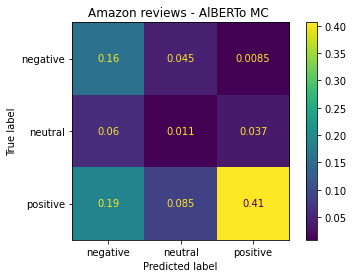

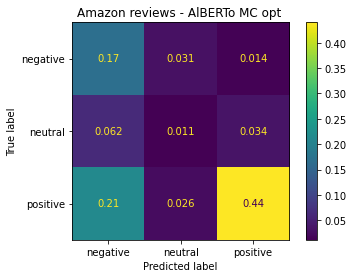

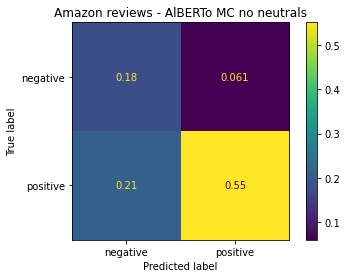

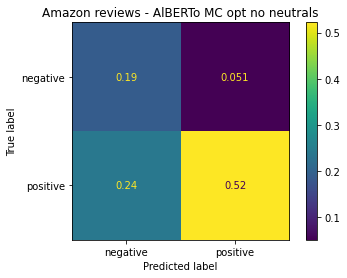

In [30]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC no neutrals\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=False, plot_confidence=False)
print("\n\n AlBERTo MC opt no neutrals\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=False, plot_confidence=False)

### AlBERTo MC/opt fine tuned - Amazon reviews



 AlBERTo MC fine-tuned





              precision    recall  f1-score   support

    negative       0.72      0.77      0.75        75
     neutral       0.25      0.05      0.09        38
    positive       0.86      0.95      0.90       239

    accuracy                           0.82       352
   macro avg       0.61      0.59      0.58       352
weighted avg       0.77      0.82      0.78       352



 AlBERTo MC opt fine-tuned





              precision    recall  f1-score   support

    negative       0.72      0.55      0.62        75
     neutral       0.00      0.00      0.00        38
    positive       0.79      0.96      0.87       239

    accuracy                           0.77       352
   macro avg       0.50      0.50      0.50       352
weighted avg       0.69      0.77      0.72       352



 AlBERTo MC fine-tuned no neutrals





              precision    recall  f1-score   support

    negative       0.90      0.81      0.85        75
    positive       0.94      0.97      0.96       239

    accuracy                           0.93       314
   macro avg       0.92      0.89      0.90       314
weighted avg       0.93      0.93      0.93       314



 AlBERTo MC opt fine-tuned no neutrals





              precision    recall  f1-score   support

    negative       0.85      0.53      0.66        75
    positive       0.87      0.97      0.92       239

    accuracy                           0.87       314
   macro avg       0.86      0.75      0.79       314
weighted avg       0.86      0.87      0.85       314



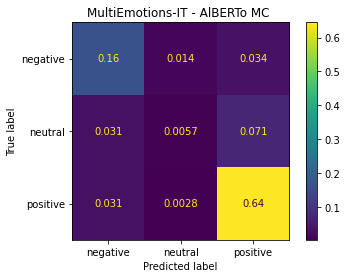

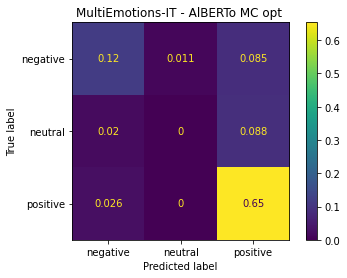

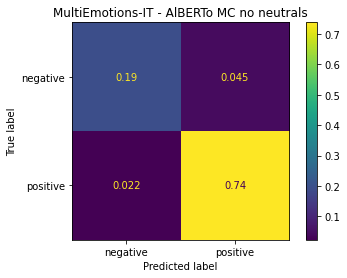

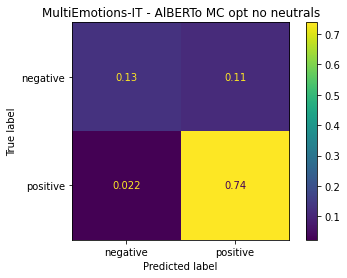

In [20]:
print("\n\n AlBERTo MC fine-tuned\n\n")
preds , trues , proba = eval_alberto(MyNetMC, 
                             "AlBERTo MC", 
                             "models/alberto_multiclass.pt", 
                             dataset_amazon_test, 
                             "MultiEmotions-IT", 
                             return_preds=True,
                             keep_neutrals=True, 
                             plot_confidence=False, 
                             fine_tuning=True, 
                             dataset_train=dataset_amazon_train,
                             logging=False,
                             model_type="MC"
                            )

print("\n\n AlBERTo MC opt fine-tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="opt"
            )

print("\n\n AlBERTo MC fine-tuned no neutrals\n\n")
eval_alberto(MyNetMC, 
             "AlBERTo MC", 
             "models/alberto_multiclass.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=False, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="MC"
            )

print("\n\n AlBERTo MC opt fine-tuned no neutrals\n\n")
eval_alberto(MyNetMCTuned, 
                 "AlBERTo MC opt", 
                 "models/alberto_multiclass_tuned.pt", 
                 dataset_amazon_test, 
                 "MultiEmotions-IT", 
                 keep_neutrals=False, 
                 plot_confidence=False, 
                 fine_tuning=True, 
                 dataset_train=dataset_amazon_train,
                 logging=False,
                 model_type="opt"
                )

###### inspect predictions

In [59]:
idx = 2
dataset_amazon_test.text.tolist()[idx] , dataset_amazon_test.labels.tolist()[idx]

('si è fuso subito bello ha tutto mandrino autoserrante molto comodo <number> stelleal primo lavoro un po piu gravoso si è fuso il motore <number> stellaassistenza sovrumana fuso lunedì tardo pomeriggio ricevuto il nuovo martedì nel pomeriggio <number> stellevalutazione complessiva <number> stelle adesso valuterò se è presente il difetto al mandrino segnalato da molti',
 1)

In [21]:
for i in range(len(preds)):
    if preds[i] != trues[i] and trues[i] == 1:
        print("\n\n", dataset_amazon_test.text.tolist()[i], i)
        print("Pred=", preds[i])
        print("True=", trues[i])



 si è fuso subito bello ha tutto mandrino autoserrante molto comodo <number> stelleal primo lavoro un po piu gravoso si è fuso il motore <number> stellaassistenza sovrumana fuso lunedì tardo pomeriggio ricevuto il nuovo martedì nel pomeriggio <number> stellevalutazione complessiva <number> stelle adesso valuterò se è presente il difetto al mandrino segnalato da molti 2
Pred= 2
True= 1


 perplesso preso durante un offerta a tempo a circa <number> euro se l avessi pagato a prezzo pieno l avrei restituito il trapano funziona abbastanza bene ma dopo due due ! ! ! fori nel cemento armato il motore era rovente dalla linea blu della bosch quindi professional mi sarei aspettato prestazioni migliori se vi serve un trapano per uso hobbistico cecate altri prodotti sicuramente più economici 41
Pred= 0
True= 1


 funzionano in parte ho preso queste salviette per occhiali perchè mi si appannavano sempre usando la mascherina pensavo che il loro effetto durasse diverse ore invece funzionano bene pe

### AlBERTo opt - Amazon reviews with stop words removal

[nltk_data] Downloading package stopwords to /home/steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




 AlBERTo MC opt no stop words





              precision    recall  f1-score   support

    negative       0.34      0.67      0.45        75
     neutral       0.11      0.16      0.13        38
    positive       0.87      0.55      0.67       239

    accuracy                           0.53       352
   macro avg       0.44      0.46      0.42       352
weighted avg       0.68      0.53      0.57       352



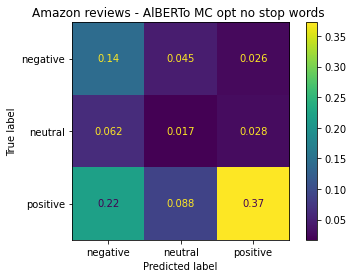

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

class AlBERTo_Preprocessing_Stop_words(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case
        self.stop_words = set(stopwords.words('italian'))

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = text_processor.pre_process_doc(text)
        filtered_text = [w for w in text if not w in self.stop_words]
        text = str(" ".join(filtered_text))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

b = AlBERTo_Preprocessing_Stop_words(do_lower_case=True)

dataset_amazon = pd.DataFrame({"text": amazon_test.text.apply(b.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)})
print("\n\n AlBERTo MC opt no stop words\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt no stop words", "models/alberto_multiclass_tuned.pt", dataset_amazon, "Amazon reviews", keep_neutrals=True, plot_confidence=False)

### Feel-it - Amazon reviews


              precision    recall  f1-score   support

    negative       0.63      0.88      0.74        75
    positive       0.96      0.84      0.90       239

    accuracy                           0.85       314
   macro avg       0.80      0.86      0.82       314
weighted avg       0.88      0.85      0.86       314




              precision    recall  f1-score   support

    negative       0.49      0.88      0.63        75
     neutral       0.00      0.00      0.00        38
    positive       0.92      0.84      0.88       239

    accuracy                           0.76       352
   macro avg       0.47      0.57      0.50       352
weighted avg       0.73      0.76      0.73       352



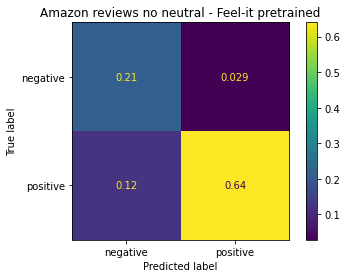

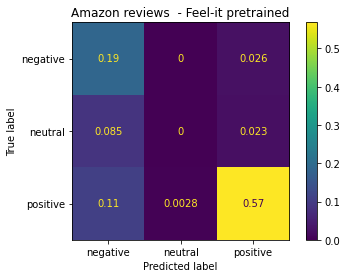

In [31]:
dataset = pd.DataFrame({"text": amazon_test.text.apply(a.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)})

eval_feelit_model(dataset, keep_neutrals=False, dataset_name="Amazon reviews", plot_confidence=False)
eval_feelit_model(dataset, keep_neutrals=True, dataset_name="Amazon reviews", plot_confidence=False)

# MultiEmotions-it

In [16]:
def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed/UNRELATED    -> 3
    """
    if row["POS"] == 0 and row["NEG"] == 0 and row["NEUT"] == 1:
        return 1
    elif row["NEG"] == 0 and row["POS"] == 1:
        return 2
    elif row["NEG"] == 1 and row["POS"] == 0:
        return 0
    else:
        return 3

##
# To split the dataset, one split, read the directly the 2 files
##
# me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it.tsv", sep='\t')
# me_train["labels"] = me_train[["POS", "NEG", "NEUT"]].apply(separate2united_labels, axis=1)

# X_train, X_test = train_test_split(me_train, test_size=0.15, random_state=42, stratify=me_train["labels"])
# X_train.to_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t', index=False)
# X_test.to_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t', index=False)

In [17]:
me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t')
me_test = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t')

me_train["text"] = me_train["comment"] 
me_test["text"] = me_test["comment"]

me_train.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
               'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
               'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)
me_test.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
               'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
               'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)

print("Train: ", len(me_train) , np.unique(me_train.labels, return_counts=True)[1]/len(me_train))
print("Test:", len(me_test) , np.unique(me_test.labels, return_counts=True)[1]/len(me_test))

print("\nAverage comment lenght Train: ", np.mean(me_train["text"].apply(len)))
print("\nAverage comment lenght Test: ", np.mean(me_test["text"].apply(len)))

me_test.head()

Train:  2754 [0.23710966 0.09114016 0.59150327 0.08024691]
Test: 486 [0.23662551 0.09053498 0.59259259 0.08024691]

Average comment lenght Train:  108.01234567901234

Average comment lenght Test:  106.6604938271605


,labels,text
0,2,Sei bella ❤️❤️
1,2,"Chi ama Riki metta like, lo amooo❤️❤️"
2,2,"Questo e un modo bellissimo per ""Celebrare"" se..."
3,1,Come si può avere la musica di sottofondo? Non...
4,0,In questi commenti mancano un po' di insulti c...


In [18]:
dataset_me_train = pd.DataFrame({"text": me_train.text.apply(a.preprocess), "idx": me_train.index, "labels": me_train["labels"].tolist()}) 
dataset_me_test = pd.DataFrame({"text": me_test.text.apply(a.preprocess), "idx": me_test.index, "labels": me_test["labels"].tolist()}) 
print("train: ", len(dataset_me_train[dataset_me_train.labels != 3]), np.unique(dataset_me_train[dataset_me_train.labels != 3].labels, return_counts=True)[1]/len(dataset_me_train[dataset_me_train.labels != 3]))
print("Test: ", len(dataset_me_test[dataset_me_test.labels != 3]), np.unique(dataset_me_test[dataset_me_test.labels != 3].labels, return_counts=True)[1]/len(dataset_me_test[dataset_me_test.labels != 3]))

lexicon_me = get_lexicon(dataset_me_test.text)
print("MultiEmotions-IT lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_me.intersection(lexicon_feel_it))/len(lexicon_me.union(lexicon_feel_it)),2))
print("MultiEmotions-IT lexicon  ∩ Sentipolc lexicon: ", round(len(lexicon_me.intersection(lexicon_sentipolc))/len(lexicon_me.union(lexicon_sentipolc)),2))

train:  2533 [0.25779708 0.09909199 0.64311094]
Test:  447 [0.25727069 0.098434   0.6442953 ]
MultiEmotions-IT lexicon  ∩ Feel-it lexicon:  0.16
MultiEmotions-IT lexicon  ∩ Sentipolc lexicon:  0.17


In [13]:
dataset_me_test.head()

,text,idx,labels
0,sei bella,0,2
1,chi ama riki metta like lo amoo,1,2
2,questo e un modo bellissimo per celebrare senz...,2,2
3,come si può avere la musica di sottofondo ? no...,3,1
4,in questi commenti mancano un po di insulti cr...,4,0


### EvSent baseline


              precision    recall  f1-score   support

    negative       0.58      0.32      0.41       115
     neutral       0.14      0.77      0.24        44
    positive       0.83      0.40      0.54       288

    accuracy                           0.42       447
   macro avg       0.52      0.50      0.40       447
weighted avg       0.70      0.42      0.48       447



 No neutrals

              precision    recall  f1-score   support

    negative       0.35      0.51      0.42       115
    positive       0.76      0.62      0.69       288

    accuracy                           0.59       403
   macro avg       0.56      0.57      0.55       403
weighted avg       0.65      0.59      0.61       403



 SMFC

              precision    recall  f1-score   support

    negative       0.27      0.31      0.29       115
     neutral       0.16      0.16      0.16        44
    positive       0.65      0.61      0.63       288

    accuracy                           0.49     

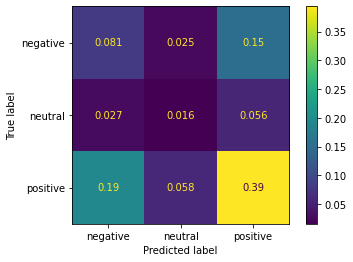

In [23]:
#%%script echo skipping
examples = dataset_me_test.loc[dataset_me_test.labels != 3]

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)

##
# Stochastic MFC
##
print("\n\n SMFC\n")
eval_mfc_baseline(dataset_me_train.loc[dataset_me_train.labels != 3], dataset_me_test.loc[dataset_me_test.labels != 3], keep_neutrals=True)

### AlBERTo MC/opt - MultiEmotions-IT



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.59      0.71      0.64       115
     neutral       0.39      0.64      0.48        44
    positive       0.96      0.78      0.86       288

    accuracy                           0.75       447
   macro avg       0.64      0.71      0.66       447
weighted avg       0.81      0.75      0.77       447



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.56      0.67      0.61       115
     neutral       0.35      0.57      0.43        44
    positive       0.93      0.77      0.84       288

    accuracy                           0.72       447
   macro avg       0.61      0.67      0.63       447
weighted avg       0.78      0.72      0.74       447



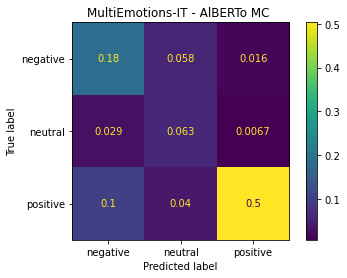

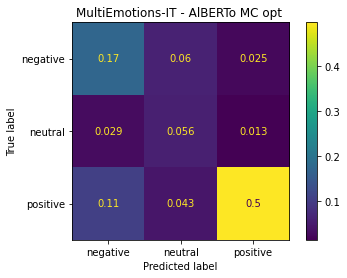

In [10]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_me_test, "MultiEmotions-IT", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_me_test, "MultiEmotions-IT", keep_neutrals=True, plot_confidence=False)

### AlBERTo MC/opt fine-tuned - MultiEmotions-IT



 AlBERTo MC fine tuned





              precision    recall  f1-score   support

    negative       0.79      0.80      0.79       115
     neutral       0.61      0.50      0.55        44
    positive       0.91      0.93      0.92       288

    accuracy                           0.85       447
   macro avg       0.77      0.74      0.75       447
weighted avg       0.85      0.85      0.85       447



 AlBERTo MC opt fine tuned





              precision    recall  f1-score   support

    negative       0.75      0.79      0.77       115
     neutral       0.72      0.41      0.52        44
    positive       0.89      0.93      0.91       288

    accuracy                           0.84       447
   macro avg       0.79      0.71      0.73       447
weighted avg       0.84      0.84      0.83       447



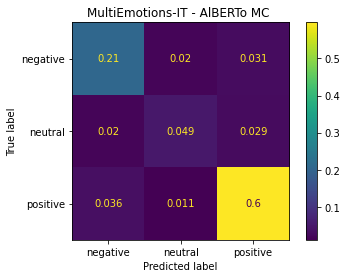

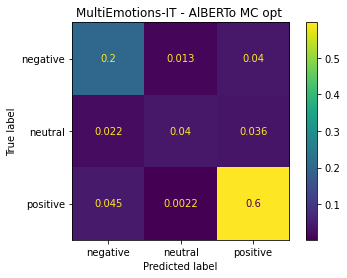

In [29]:
print("\n\n AlBERTo MC fine tuned\n\n")
preds , trues , proba = eval_alberto(MyNetMC, 
                         "AlBERTo MC", 
                         "models/alberto_multiclass.pt", 
                         dataset_me_test, 
                         "MultiEmotions-IT", 
                         return_preds=True,
                         keep_neutrals=True, 
                         plot_confidence=False, 
                         fine_tuning=True, 
                         dataset_train=dataset_me_train,
                         logging=False,
                         model_type="MC"
                        )
print("\n\n AlBERTo MC opt fine tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_me_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_me_train,
             logging=False,
             model_type="opt"
            )

##### inspect comments - neutrals

In [28]:
dataset_me_test[dataset_me_test.text.str.contains("anche se ascolto")]

,text,idx,labels
36,anche se ascolto l originale ho comunque in te...,36,1


In [30]:
for i in range(len(preds)):
    if preds[i] != trues[i] and trues[i] == 1:
        print("\n\n", dataset_me_test[dataset_me_test.labels != 3].text.tolist()[i], i)
        print("Pred=", preds[i])
        print("True=", trues[i])



 come si può avere la musica di sottofondo ? non quella dei vangelis ma questa ! 3
Pred= 0
True= 1


 date la possibilità di fare la dpesa online che risulta essere tutto bloccato 17
Pred= 0
True= 1


 presidente del consiglio le brutte intenzioni la maleducazione la tua brutta figura di ieri sera 27
Pred= 0
True= 1


 anche se ascolto l originale ho comunque in testa le brutte intenzioni e la tua maleducazione 34
Pred= 2
True= 1


 che bello quando guardavamo sanremo e non c era il coronavirus 56
Pred= 2
True= 1


 in questo periodo le mangio tt le mattine con marmellata e the 100
Pred= 2
True= 1


 voglio quel carrello in smash bros 122
Pred= 2
True= 1


 a me le spese di consegna ammontano a <number> sia che prenda due cuscini sia che prenda tavolo e sedie per il balcone non capisco se è una cosa dovuta al coronavirus perché prima mi dava <number> o <number> se non sbaglio è questa la cifra corretta per tutti gli articoli ? 200
Pred= 0
True= 1


 è nuova questa canzone ? 205
Pred=

### Feel-IT - MultiEmotions-IT


              precision    recall  f1-score   support

    negative       0.50      0.90      0.64       115
     neutral       0.00      0.00      0.00        44
    positive       0.88      0.72      0.79       288

    accuracy                           0.70       447
   macro avg       0.46      0.54      0.48       447
weighted avg       0.70      0.70      0.68       447




              precision    recall  f1-score   support

    negative       0.57      0.90      0.70       115
    positive       0.95      0.72      0.82       288

    accuracy                           0.77       403
   macro avg       0.76      0.81      0.76       403
weighted avg       0.84      0.77      0.78       403



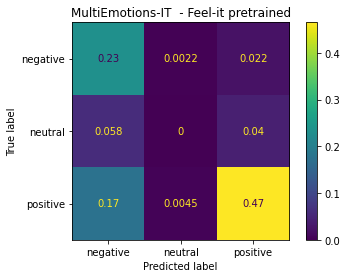

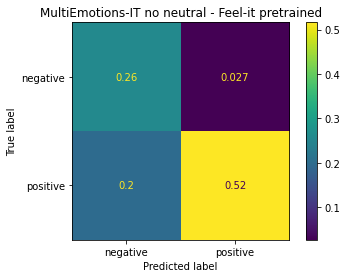

In [11]:
eval_feelit_model(dataset_me_test, keep_neutrals=True, dataset_name="MultiEmotions-IT", plot_confidence=False)
eval_feelit_model(dataset_me_test, keep_neutrals=False, dataset_name="MultiEmotions-IT", plot_confidence=False)

# Coadapt sentiment

In [19]:
def label_string2int(row):
    if row["label"] == "neutral":
        return 1
    elif row["label"] == "negative":
        return 0
    elif row["label"] == "positive":
        return 2

coadapt = pd.read_json(PATH + "Coadapt/coadapt_sentiment.json")
coadapt = pd.DataFrame({"text": coadapt.text.apply(a.preprocess), "idx": coadapt.index, "labels": coadapt[["label"]].apply(label_string2int, axis=1)}) 

print("Train: ", len(coadapt) , np.unique(coadapt.labels, return_counts=True)[1]/len(coadapt))
print("\nAverage text lenght Train: ", np.mean(coadapt["text"].apply(len)))

lexicon_coadapt = get_lexicon(coadapt.text)
print("\nCoadapt lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_coadapt.intersection(lexicon_feel_it))/len(lexicon_coadapt.union(lexicon_feel_it)),2))
print("Coadapt lexicon  ∩ Sentipolc lexicon: ", round(len(lexicon_coadapt.intersection(lexicon_sentipolc))/len(lexicon_coadapt.union(lexicon_sentipolc)),2))

coadapt.head()

Train:  358 [0.60614525 0.08379888 0.31005587]

Average text lenght Train:  206.00279329608938

Coadapt lexicon  ∩ Feel-it lexicon:  0.15
Coadapt lexicon  ∩ Sentipolc lexicon:  0.17


,text,idx,labels
0,maddalena uno dei miei capi mi ha chiesto di c...,0,0
1,ho ricevuto la telefonata di una cliente che n...,1,0
2,mi chiama una collega m per sapere se è a arri...,2,0
3,fra le mie mansioni c è anche la gestione dell...,3,0
4,ho avuto un paio di telefonate con familiari e...,4,0


### EvSent baseline

In [12]:
#%%script echo skipping
examples = coadapt

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)


              precision    recall  f1-score   support

    negative       0.77      0.41      0.53       217
     neutral       0.09      0.43      0.14        30
    positive       0.46      0.38      0.41       111

    accuracy                           0.40       358
   macro avg       0.44      0.41      0.36       358
weighted avg       0.61      0.40      0.46       358



 No neutrals

              precision    recall  f1-score   support

    negative       0.73      0.59      0.65       217
    positive       0.42      0.57      0.48       111

    accuracy                           0.59       328
   macro avg       0.57      0.58      0.57       328
weighted avg       0.62      0.59      0.60       328



### AlBERTo MC/opt - Coadapt sentiment



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.83      0.72      0.77       217
     neutral       0.13      0.40      0.20        30
    positive       0.76      0.53      0.62       111

    accuracy                           0.63       358
   macro avg       0.57      0.55      0.53       358
weighted avg       0.75      0.63      0.68       358



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.80      0.71      0.75       217
     neutral       0.12      0.37      0.18        30
    positive       0.74      0.50      0.60       111

    accuracy                           0.61       358
   macro avg       0.55      0.53      0.51       358
weighted avg       0.72      0.61      0.66       358



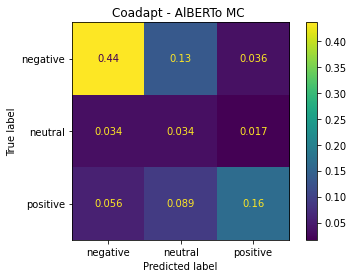

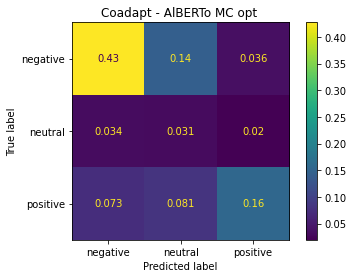

In [43]:
print("\n\n AlBERTo MC\n\n")
preds , trues , proba = eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", coadapt, "Coadapt", keep_neutrals=True, return_preds=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", coadapt, "Coadapt", keep_neutrals=True, plot_confidence=False)

##### inspect samples

In [48]:
coadapt[coadapt.text.str.contains("finito adesso primo colloqui")]

,text,idx,labels
64,finito adesso primo colloqui sensazione molto ...,64,1


In [49]:
for i in range(len(preds)):
    if preds[i] != trues[i] and trues[i] == 2:
        print("\n\n", coadapt[coadapt.labels != 3].text.tolist()[i], i)
        print("Pred=", preds[i])
        print("True=", trues[i])



 trasferta in svizzera presso un azienda da cui eri stato addirittura nel <number> ! viaggio con neve lungo il percorso come allora umore molto positivo misto di malinconia per il passato e di soddisfazione per il concretizzarsi di questa opportunità accoglienza cordiale percezione di ospitalità <number> ore passate a discutere argomenti intetessanti rientro con viaggio di altre <number> ore ma pochissima stanchezza felicità abbastanza intensa <number> sensazione di leggerezza alla testa 10
Pred= 0
True= 2


 la mattina ho un appuntamento con un collega per definire l orario del premessa siamo in emergenza aule la direzione didattica verso natale aveva voluto imporre un orario irricevibile dal punto di vista didattico come delegati per la didattica ci eravamo opposti ed io ero stato tra i più critici l incontro del <number> febbraio rappresenta un tentativo di dimostrare la fattibilità di una soluzione più accettabile in una mattinata siano riusciti a far quadrare tutto in modo veram

### Feel-it - Coadapt sentiment


              precision    recall  f1-score   support

    negative       0.85      0.93      0.89       217
    positive       0.83      0.67      0.74       111

    accuracy                           0.84       328
   macro avg       0.84      0.80      0.81       328
weighted avg       0.84      0.84      0.84       328




              precision    recall  f1-score   support

    negative       0.79      0.93      0.86       217
     neutral       0.00      0.00      0.00        30
    positive       0.72      0.67      0.69       111

    accuracy                           0.77       358
   macro avg       0.50      0.53      0.52       358
weighted avg       0.70      0.77      0.73       358



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


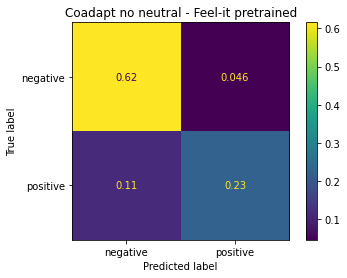

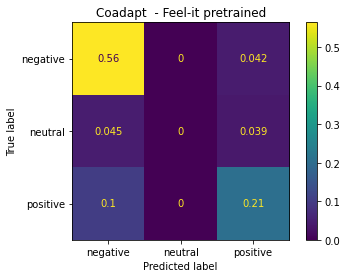

In [29]:
eval_feelit_model(coadapt, keep_neutrals=False, dataset_name="Coadapt", plot_confidence=False)
eval_feelit_model(coadapt, keep_neutrals=True, dataset_name="Coadapt", plot_confidence=False)

# AriEmozione dataset

In [20]:
ari_train = pd.read_csv(PATH + "Aria/ariaset_train.tsv", sep='\t', encoding="latin-1", names=["names", "text", "labels", "confidence", "?"])
ari_train.drop(["?", "names"], axis=1, inplace=True)
ari_train.dropna(inplace=True)

ari_test = pd.read_csv(PATH + "Aria/ariaset_test.tsv", sep='\t', encoding="latin-1", names=["names", "text", "labels", "confidence", "?"])
ari_test.drop(["?", "names"], axis=1, inplace=True)
ari_test.dropna(inplace=True)

print("Train: ", len(ari_train) , np.unique(ari_train.labels, return_counts=True)[1]/len(ari_train))
print("Test:", len(ari_test) , np.unique(ari_test.labels, return_counts=True)[1]/len(ari_test))

print("\nAverage piece lenght Train: ", np.mean(ari_train["text"].apply(len)))
print("\nAverage piece lenght Test: ", np.mean(ari_test["text"].apply(len)))

ari_test.head()

Train:  1962 [0.14729867 0.14729867 0.13965341 0.01427115 0.08460754 0.21049949
 0.25637105]
Test: 250 [0.12  0.148 0.156 0.044 0.06  0.256 0.216]

Average piece lenght Train:  73.07798165137615

Average piece lenght Test:  72.804


,text,labels,confidence
0,Infelice e sventurato potrà farmi ingiusto fat...,Ammirazione,Totalmente sicura
1,La mia fede e l'onor mio pur fra l'onde d...,Gioia,Totalmente sicura
2,"Fuggite dal cuore, noiose mie pene",Rabbia,Totalmente sicura
3,AGARISTA ed ORONTA,Nessuna,totalmente sicura
5,Già stringo..,Amore,Abbastanza sicura


In [21]:
def emotion2label(row):
    if row["labels"] in ["Gioia", "Ammirazione", "Amore"]:
        return 2
    elif row["labels"] in ["Rabbia", "Tristezza", "Paura"]:
        return 0
    else:
        return 3

dataset_ari_train = pd.DataFrame({"text": ari_train.text.apply(a.preprocess), "idx": ari_train.index, "labels": ari_train[["labels"]].apply(emotion2label, axis=1)}) 
dataset_ari_test = pd.DataFrame({"text": ari_test.text.apply(a.preprocess), "idx": ari_test.index, "labels": ari_test[["labels"]].apply(emotion2label, axis=1)}) 
print("Train: ", len(dataset_ari_train[dataset_ari_train.labels != 3]) , np.unique(dataset_ari_train[dataset_ari_train.labels != 3].labels, return_counts=True)[1]/len(dataset_ari_train[dataset_ari_train.labels != 3]))
print("Test:", len(dataset_ari_test[dataset_ari_test.labels != 3]) , np.unique(dataset_ari_test[dataset_ari_test.labels != 3].labels, return_counts=True)[1]/len(dataset_ari_test[dataset_ari_test.labels != 3]))

lexicon_ari = get_lexicon(dataset_ari_test.text)
print("\nAriEmozione lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_ari.intersection(lexicon_feel_it))/len(lexicon_ari.union(lexicon_feel_it)),2))
print("AriEmozione lexicon  ∩ Sentipolc lexicon: ", round(len(lexicon_ari.intersection(lexicon_sentipolc))/len(lexicon_ari.union(lexicon_sentipolc)),2))

Train:  1934 [0.55946225 0.44053775]
Test: 239 [0.55648536 0.44351464]

AriEmozione lexicon  ∩ Feel-it lexicon:  0.06
AriEmozione lexicon  ∩ Sentipolc lexicon:  0.07


### EvSent baseline


              precision    recall  f1-score   support

    negative       0.72      0.32      0.44       133
     neutral       0.00      0.00      0.00         0
    positive       0.55      0.31      0.40       106

    accuracy                           0.31       239
   macro avg       0.42      0.21      0.28       239
weighted avg       0.65      0.31      0.42       239



 No neutrals

              precision    recall  f1-score   support

    negative       0.64      0.59      0.61       133
    positive       0.53      0.58      0.56       106

    accuracy                           0.59       239
   macro avg       0.58      0.59      0.58       239
weighted avg       0.59      0.59      0.59       239



 SMFC

              precision    recall  f1-score   support

    negative       0.55      0.58      0.56       133
    positive       0.43      0.41      0.42       106

    accuracy                           0.50       239
   macro avg       0.49      0.49      0.49     

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


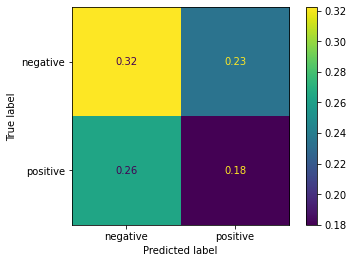

In [32]:
#%%script echo skipping
examples = dataset_ari_test[dataset_ari_test.labels != 3]

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)

##
# Stochastic MFC
##
print("\n\n SMFC\n")
eval_mfc_baseline(dataset_ari_train[dataset_ari_train.labels != 3], dataset_ari_test[dataset_ari_test.labels != 3], keep_neutrals=False)

### AlBERTo MC/opt - AriEmotions



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.68      0.69      0.68       133
     neutral       0.00      0.00      0.00         0
    positive       0.78      0.27      0.41       106

    accuracy                           0.51       239
   macro avg       0.49      0.32      0.36       239
weighted avg       0.72      0.51      0.56       239



 AlBERTo MC opt




/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

    negative       0.66      0.59      0.62       133
     neutral       0.00      0.00      0.00         0
    positive       0.72      0.32      0.44       106

    accuracy                           0.47       239
   macro avg       0.46      0.30      0.36       239
weighted avg       0.69      0.47      0.54       239



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


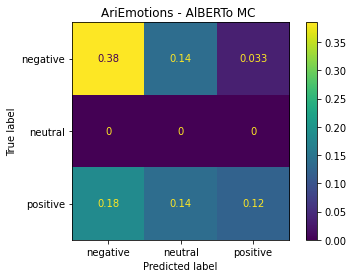

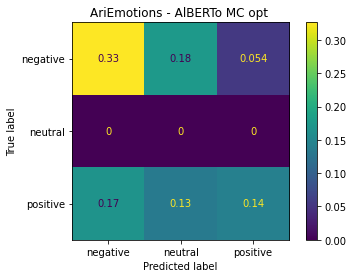

In [26]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_ari_test, "AriEmotions", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_ari_test, "AriEmotions", keep_neutrals=True, plot_confidence=False)

### AlBERTo MC/opt fine tuned - AriEmotions



 AlBERTo MC fine tuned





              precision    recall  f1-score   support

    negative       0.75      0.85      0.80       133
    positive       0.78      0.65      0.71       106

    accuracy                           0.76       239
   macro avg       0.76      0.75      0.75       239
weighted avg       0.76      0.76      0.76       239



 AlBERTo MC opt fine tuned





              precision    recall  f1-score   support

    negative       0.72      0.80      0.75       133
    positive       0.70      0.60      0.65       106

    accuracy                           0.71       239
   macro avg       0.71      0.70      0.70       239
weighted avg       0.71      0.71      0.71       239



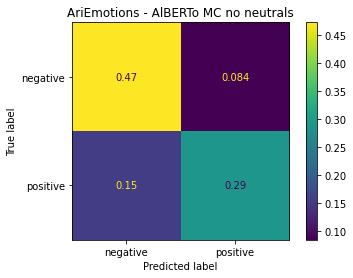

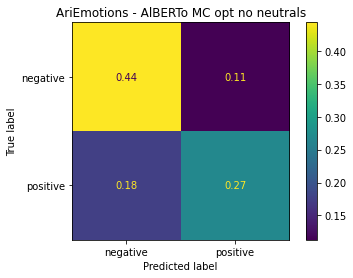

In [32]:
print("\n\n AlBERTo MC fine tuned\n\n")
eval_alberto(MyNetMC, 
             "AlBERTo MC", 
             "models/alberto_multiclass.pt", 
             dataset_ari_test, 
             "AriEmotions", 
             keep_neutrals=False, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_ari_train,
             logging=False,
             model_type="MC"
            )
print("\n\n AlBERTo MC opt fine tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_ari_test, 
             "AriEmotions", 
             keep_neutrals=False, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_ari_train,
             logging=False,
             model_type="opt"
            )

### Feel-it model - AriEmotions


              precision    recall  f1-score   support

    negative       0.64      0.91      0.75       133
    positive       0.76      0.36      0.49       106

    accuracy                           0.67       239
   macro avg       0.70      0.63      0.62       239
weighted avg       0.69      0.67      0.63       239




              precision    recall  f1-score   support

    negative       0.64      0.90      0.75       133
     neutral       0.00      0.00      0.00         0
    positive       0.77      0.34      0.47       106

    accuracy                           0.65       239
   macro avg       0.47      0.41      0.41       239
weighted avg       0.69      0.65      0.62       239



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


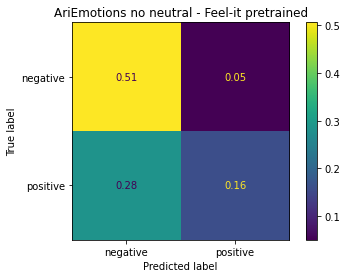

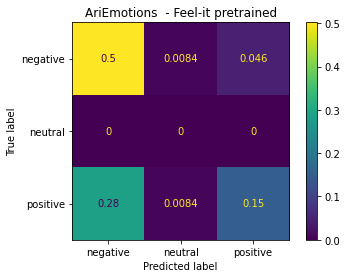

In [34]:
eval_feelit_model(dataset_ari_test, keep_neutrals=False, dataset_name="AriEmotions", plot_confidence=False)
eval_feelit_model(dataset_ari_test, keep_neutrals=True, dataset_name="AriEmotions", plot_confidence=False)

# Trip-maml

In [22]:
def segments2text(row):
    return " ".join([ e.split("/")[0] for sub_segment in row["segments"] for e in sub_segment.split(" ")]) 

def rating2sentiment(row):
    """
        Returns the polarity depending on the rating of the review
    """
    if row["ratingOverall"] == 3:
        return 1
    elif row["ratingOverall"] > 3:
        return 2
    elif row["ratingOverall"] < 3:
        return 0

trip_train = pd.read_json(PATH + "Trip-maml/italian_training.json", lines=True)
dataset_trip_train = pd.DataFrame({"text": trip_train[["segments"]].apply(segments2text, axis=1), "idx": trip_train.index, "labels": trip_train[["ratingOverall"]].apply(rating2sentiment, axis=1)}) 

trip_test = pd.read_json(PATH + "Trip-maml/italian_test.json", lines=True)
dataset_trip_test = pd.DataFrame({"text": trip_test[["segments"]].apply(segments2text, axis=1), "idx": trip_test.index, "labels": trip_test[["ratingOverall"]].apply(rating2sentiment, axis=1)}) 

print("Train: ", len(dataset_trip_train) , np.unique(dataset_trip_train.labels, return_counts=True)[1]/len(dataset_trip_train))
print("Test:  ", len(dataset_trip_test) , np.unique(dataset_trip_test.labels, return_counts=True)[1]/len(dataset_trip_test))

print("\nAverage piece lenght Train: ", np.mean(dataset_trip_train["text"].apply(len)))
print("\nAverage piece lenght Test: ", np.mean(dataset_trip_test["text"].apply(len)))

lexicon_trip = get_lexicon(dataset_trip_test.text)
print("\nTrip-maml lexicon  ∩ Feel-it lexicon: ", round(len(lexicon_trip.intersection(lexicon_feel_it))/len(lexicon_trip.union(lexicon_feel_it)),2))
print("Trip-maml lexicon  ∩ Sentipolc lexicon: ", round(len(lexicon_trip.intersection(lexicon_sentipolc))/len(lexicon_trip.union(lexicon_sentipolc)),2))

Train:  292 [0.12328767 0.16438356 0.71232877]
Test:   125 [0.136 0.16  0.704]

Average piece lenght Train:  527.8972602739726

Average piece lenght Test:  575.2

Trip-maml lexicon  ∩ Feel-it lexicon:  0.13
Trip-maml lexicon  ∩ Sentipolc lexicon:  0.15


### EvSent baseline


              precision    recall  f1-score   support

    negative       0.80      0.47      0.59        17
     neutral       0.10      0.10      0.10        20
    positive       0.78      0.84      0.81        88

    accuracy                           0.67       125
   macro avg       0.56      0.47      0.50       125
weighted avg       0.67      0.67      0.67       125



 No neutrals

              precision    recall  f1-score   support

    negative       0.58      0.65      0.61        17
    positive       0.93      0.91      0.92        88

    accuracy                           0.87       105
   macro avg       0.75      0.78      0.77       105
weighted avg       0.87      0.87      0.87       105



 SMFC

              precision    recall  f1-score   support

    negative       0.09      0.06      0.07        17
     neutral       0.06      0.05      0.05        20
    positive       0.67      0.74      0.70        88

    accuracy                           0.54     

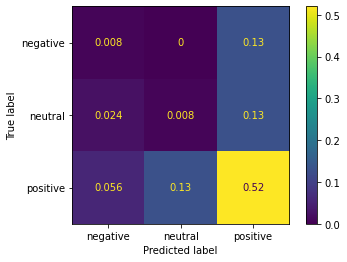

In [31]:
#%%script echo skipping
examples = dataset_trip_test[dataset_trip_test.labels != 3]

preds , true , pbar = np.full(len(examples), -1) , np.full(len(examples), -1) , tqdm(total=len(examples))
index , lock , p = 0 , Lock() , ThreadPool(processes=10)
for text , label in zip(examples.text, examples.labels):
    p.apply_async(worker, (label, text, pbar, preds, true, lock))
p.close(); p.join()
pbar.close()
assert not np.any(preds == -1) and not np.any(true == -1)
print(classification_report(true, preds, target_names=["negative", "neutral", "positive"]))

##
# No Neutrals
# reassing labels so that no neutrals are present
##
print("\n\n No neutrals\n")
evsent_remove_neutrals(true, preds)

##
# Stochastic MFC
##
print("\n\n SMFC\n")
eval_mfc_baseline(dataset_trip_test, dataset_trip_test, keep_neutrals=True)

### AlBERTo MC/opt - Trip-maml



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.59      0.76      0.67        17
     neutral       1.00      0.05      0.10        20
    positive       0.84      0.98      0.91        88

    accuracy                           0.80       125
   macro avg       0.81      0.60      0.56       125
weighted avg       0.83      0.80      0.74       125



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.52      0.94      0.67        17
     neutral       0.00      0.00      0.00        20
    positive       0.88      0.94      0.91        88

    accuracy                           0.79       125
   macro avg       0.47      0.63      0.53       125
weighted avg       0.69      0.79      0.73       125



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


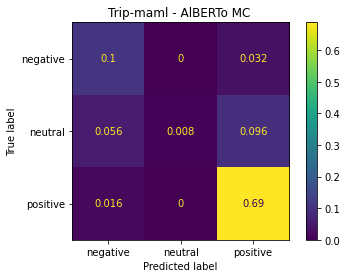

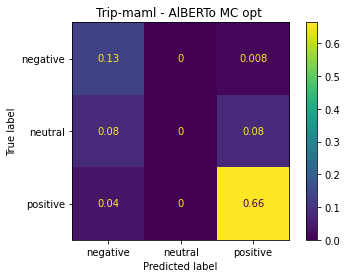

In [40]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_trip_test, "Trip-maml", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_trip_test, "Trip-maml", keep_neutrals=True, plot_confidence=False)

### AlBERTo MC/opt fine tuned - Trip-maml



 AlBERTo MC fine tuned





              precision    recall  f1-score   support

    negative       0.61      0.82      0.70        17
     neutral       0.33      0.05      0.09        20
    positive       0.85      0.95      0.90        88

    accuracy                           0.79       125
   macro avg       0.60      0.61      0.56       125
weighted avg       0.73      0.79      0.74       125



 AlBERTo MC opt fine tuned





              precision    recall  f1-score   support

    negative       0.80      0.24      0.36        17
     neutral       0.60      0.15      0.24        20
    positive       0.75      0.98      0.85        88

    accuracy                           0.74       125
   macro avg       0.72      0.45      0.48       125
weighted avg       0.73      0.74      0.68       125



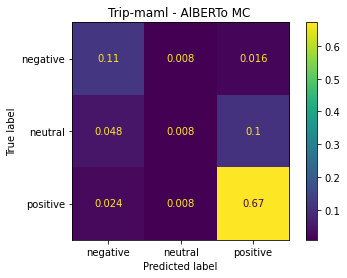

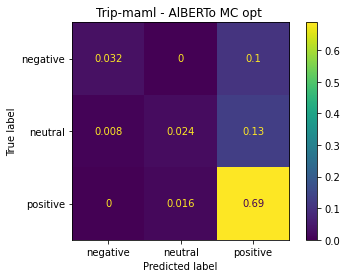

In [51]:
print("\n\n AlBERTo MC fine tuned\n\n")
preds , trues , proba = eval_alberto(MyNetMC, 
                         "AlBERTo MC", 
                         "models/alberto_multiclass.pt", 
                         dataset_trip_test, 
                         "Trip-maml", 
                         keep_neutrals=True, 
                         return_preds=True,
                         plot_confidence=False, 
                         fine_tuning=True, 
                         dataset_train=dataset_trip_train,
                         logging=False,
                         model_type="MC"
                        )
print("\n\n AlBERTo MC opt fine tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_trip_test, 
             "Trip-maml", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_trip_train,
             logging=False,
             model_type="opt"
            )

##### inspect samples

In [55]:
dataset_trip_test[dataset_trip_test.text.str.contains("Leggendo le rece")]

,text,idx,labels
106,Leggendo le recensioni e guardando le foto ero...,106,0


In [53]:
for i in range(len(preds)):
    if preds[i] != trues[i] and trues[i] == 0:
        print("\n\n", dataset_trip_test.text.tolist()[i], i)
        print("Pred=", preds[i])
        print("True=", trues[i])



 Sono rimasto particolarmente deluso dall ' esperienza in questo Hotel , e lo sconsiglio caldamente a tutti , se ci andate commettete un grave errore . Innanzitutto premetto che , quando si entra , sembra di entrare sul serio in un grande Hotel , perché l ' ingresso e bello e scenografico . I guai arrivano dopo . Quando ho chiesto dove fosse la mia stanza , sono stato accompagnato attraverso uno squallido pozzo luce all ' interno di uno stabile vicino , dove ho trovato ad accoglier mi una camera singola degna di un film Alvaro_Vitali . Innanzitutto dal bagno proveniva una puzza infernale , e potete immaginare quanto sia stato piacevole dormire la notte in queste condizioni . La doccia non aveva neanche quella struttura minima di protezione ( formata dalle classiche 4 pareti di plastica ) che ormai si trova anche nei peggiori ostelli di quart'ordine . All'interno della camera mancava il frigobar , ed all ' interno dell ' armadio non c ' era neanche il cuscino supplementare ( che io ho

### Feel-it model - Trip-maml


              precision    recall  f1-score   support

    negative       0.77      1.00      0.87        17
    positive       1.00      0.94      0.97        88

    accuracy                           0.95       105
   macro avg       0.89      0.97      0.92       105
weighted avg       0.96      0.95      0.95       105



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.53      1.00      0.69        17
     neutral       0.00      0.00      0.00        20
    positive       0.89      0.94      0.92        88

    accuracy                           0.80       125
   macro avg       0.47      0.65      0.54       125
weighted avg       0.70      0.80      0.74       125



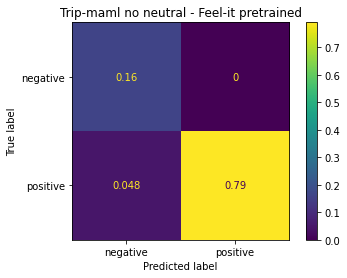

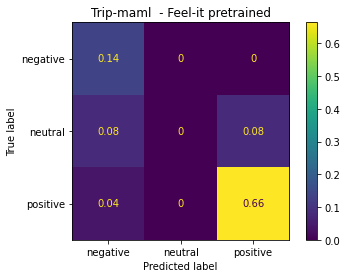

In [47]:
eval_feelit_model(dataset_trip_test, keep_neutrals=False, dataset_name="Trip-maml", plot_confidence=False)
eval_feelit_model(dataset_trip_test, keep_neutrals=True, dataset_name="Trip-maml", plot_confidence=False)

#### Further error analysis
Use EvSent to compute the number of words with either a positive or negative meaning, in order to spot samples clearly positive or clearly negative.
Then use AlBERTo or Feel-IT to see the its behaviour on samples that have no clear polarity orientation.

In [59]:
import pickle

a_file = open(PATH + "sentiment_lexicon.pkl", "rb")
sentiment_lexicon = pickle.load(a_file)
a_file.close()

In [60]:
def join_tokenized_token(sa):
    ret = []
    for token in sa:
        if token in ("<", ">", "/"):
            continue
        if token[:2] == "##":
            ret[-1] = ret[-1] + token[2:]
        else:
            ret.append(token)
    return ret


def add_to_sentiment_lexicon(dataset):
    for sub_tokenized_sample in tqdm(dataset.text.apply(lambda x: tok.tokenize(x))):
        tokenized_sample = join_tokenized_token(sub_tokenized_sample)
        for token in tokenized_sample:
            if token not in sentiment_lexicon:
                polarity = evSent(token)
                sentiment_lexicon[token] = polarity

#build the sentiment lexicon
add_to_sentiment_lexicon(dataset_sentipolc[dataset_sentipolc.labels != 3])
add_to_sentiment_lexicon(dataset_feel_it)
add_to_sentiment_lexicon(dataset_amazon_test)
add_to_sentiment_lexicon(dataset_me_test)
add_to_sentiment_lexicon(coadapt)
add_to_sentiment_lexicon(dataset_ari_test)
add_to_sentiment_lexicon(dataset_trip_test)

# a_file = open(PATH + "sentiment_lexicon.pkl", "wb")
# pickle.dump(sentiment_lexicon, a_file)
# a_file.close()

In [56]:
def score_dataset(dataset):
    ret , ret2 = [] , []
    for sub_tokenized_sample in tqdm(dataset.text.apply(lambda x: tok.tokenize(x))):
        tokenized_sample = join_tokenized_token(sub_tokenized_sample)
        score = 0
        has_neg , has_pos = False , False
        for token in tokenized_sample:
            if sentiment_lexicon[token] == 2:
                score += 1
                has_pos = True
            elif sentiment_lexicon[token] == 0:
                score -= 1 
                has_neg = True
        ret.append(score)
        ret2.append(has_neg and has_pos)
    return np.array(ret) , np.array(ret2)

scores , has_boths = score_dataset(dataset_sentipolc[dataset_sentipolc.labels != 3])

In [58]:
for i , text in enumerate(dataset_sentipolc[dataset_sentipolc.labels != 3].text.tolist()):
    print(scores[i], has_boths[i] , dataset_sentipolc[dataset_sentipolc.labels != 3].labels.tolist()[i], " --> " ,text)

1 False 1  -->  tra <number> minuti presentazione piano scuola del governo <hashtag> renzi </hashtag> <hashtag> passo do pop as so </hashtag> <hashtag> la buona scuola </hashtag> stay tuned
1 False 2  -->  <user> alle <number> appuntamento su <url> <hashtag> italia rip arte </hashtag> <hashtag> la buona scuola </hashtag> <hashtag> grandin segn anti </hashtag> <hashtag> buon lavoro </hashtag>
1 False 0  -->  <hashtag> la buona scuola </hashtag> gli <hashtag> evangelisti </hashtag> <hashtag> digitali </hashtag> non devono essere già dentro la scuola esempi <user> <user> <hashtag> nuove profession i </hashtag>
1 False 1  -->  riforma scuola tutto il discorso di renzi su os <url> <hashtag> la buona scuola </hashtag> <hashtag> riforma scuola </hashtag>
2 False 1  -->  <user> <user> <hashtag> la buona scuola </hashtag> basta supplenti ma anche coraggio nel valutare i prof <url>
1 False 2  -->  <user> alle <number> appuntamento su <url> <hashtag> italia rip arte </hashtag> <hashtag> la buona 

1 False 1  -->  new post la buona scuola il pd savonese invita i cittadini a partecipare al dibattito sul fut <url>
1 False 0  -->  in italia la scuola è l unica squadra in cui i giocatori non amano giocare e gli allenatori sono considerati nemici lontana <hashtag> la buona scuola </hashtag>
1 False 1  -->  la buona scuola inizia al capuana via <user>
3 False 1  -->  la buona scuola dsga con piena automomia e responsabilità in solido <url> <hashtag> la buona scuola </hashtag>
2 False 1  -->  la buona scuola revisione clil <url> <hashtag> la buona scuola </hashtag>
1 False 0  -->  <user> i docenti falsi invalidi ad agrigento come a milano quale modello educativo potranno essere per i loro alunni ? <hashtag> la buona scuola </hashtag>
1 False 1  -->  <user> partecipato contribuito scritto anche mail ma non mi avete risposto <hashtag> la buona scuola </hashtag>
2 False 2  -->  punto e a capo con <hashtag> renzi </hashtag> <hashtag> la buona scuola </hashtag> <hashtag> lavolta buona </hash

1 False 2  -->  <hashtag> briga amici </hashtag> che difendeva gabriele è l amore 😍
0 False 1  -->  ora si svuota tutto lo studio hahahahhahahahaha <hashtag> amici </hashtag>
0 False 2  -->  alla ricerca del niruana 😽 😂 <hashtag> feder aica maggiore nne </hashtag> <hashtag> ella peppa </hashtag> <hashtag> bell ass sei </hashtag> <url>
-1 False 2  -->  harry mi ha fatto letteralmente perdere la testa by harrystringimi
1 False 2  -->  <user> 🌴 cita e rispondi old magcon 🍍 foto preferita di matt ? amore mio <url>
-1 False 0  -->  senza te sento che la mia vita é difficile ma no é finita
1 False 0  -->  ultimamente le band sono divise in chi molla e chi annuncia super tour dove ovviamente l italia non esiste
2 False 2  -->  <user> metteresti mi piace qui ? ricambio in qualsiasi modo grazie se lo fai <url>
0 False 1  -->  <user> ti prego mi fai una chat con michael c ? non ti chiedo nient altro dopo ti lascerò stare per sempre posso affidarmi solo a te
1 False 1  -->  io a questa anteprima 

0 False 1  -->  dalla lettera de <hashtag> mengoni </hashtag> ai corinzi parola de <hashtag> noemi </hashtag> er vescovo de noto c ha l ics e sta fatto daje <url>
1 False 2  -->  <user> grazie a te perché pensi un po a noi ! xx
1 False 2  -->  amore mio <url>
0 False 0  -->  una volta mi adoravano tutti
1 False 2  -->  il mio piccolo amore mentre vede <user> <user> <url>
1 False 1  -->  <user> anche questo per favore 😦
2 False 2  -->  <user> bene grazie ancora io uso spesso lumia dove ci sono solo app non vostre posso usarle serenamente per aprire le auto ?
1 False 2  -->  <user> grazie mille signor vincenzo che belle foto saluti non posso rispondere per dm perché non mi segui <sad>
0 False 3  -->  <user> come devo fare per avere una tua risposta ? 😭 x
0 False 0  -->  italia tappa buchi ha salvato le banche tedesche e francesi <url>
0 False 1  -->  <user> taci va quasi quasi vado a fare un giretto dal mio amicone interiorizzatore chissà come sta ? !
2 True 0  -->  christì fai meglio a 

In [40]:
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[has_boths], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores == 0], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[np.logical_and(scores == 0, has_boths)], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[np.logical_and(scores == 0, ~has_boths)], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores >= 2], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores >= 3], return_counts=True))
print(np.unique(dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores <= -1], return_counts=True))

(array([0, 1, 2]), array([95, 26,  7]))
(array([0, 1, 2]), array([74, 35, 19]))
(array([0, 1, 2]), array([150, 225,  70]))
(array([0, 1, 2]), array([75, 20,  3]))
(array([0, 1, 2]), array([ 75, 205,  67]))
(array([0, 1, 2]), array([119, 159,  85]))
(array([0, 1, 2]), array([17, 26, 16]))
(array([0, 1, 2]), array([34, 20,  5]))



              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964



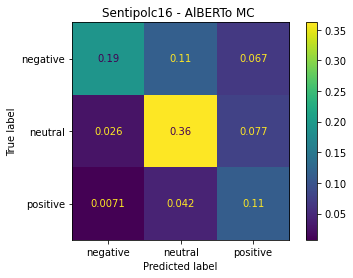

In [29]:
preds , trues , proba = eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_sentipolc, "Sentipolc16", return_preds=True, keep_neutrals=True, plot_confidence=False)
assert np.all(trues == dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy())

In [53]:
fig = go.Figure()

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[has_boths], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Has both'))
fig.add_trace(go.Violin(y=preds[has_boths], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred has both'))

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores == 0], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Neutral lexicon score'))
fig.add_trace(go.Violin(y=preds[scores == 0], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred neutral lexicon score'))

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[np.logical_and(scores == 0, has_boths)], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Neutral lexicon score + has both'))
fig.add_trace(go.Violin(y=preds[np.logical_and(scores == 0, has_boths)], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred neutral lexicon score + has both'))

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[np.logical_and(scores == 0, ~has_boths)], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Neutral lexicon score + not has both'))
fig.add_trace(go.Violin(y=preds[np.logical_and(scores == 0, ~has_boths)], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred neutral lexicon score + not has both'))

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores >= 2], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Score >= 2'))
fig.add_trace(go.Violin(y=preds[scores >= 2], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred score >= 2'))

fig.add_trace(go.Violin(y=dataset_sentipolc[dataset_sentipolc.labels != 3].labels.to_numpy()[scores <= -1], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='Score <= -1'))
fig.add_trace(go.Violin(y=preds[scores <= -1], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='Pred score <= -1'))

fig.update_layout(
    title="Distribution of sentiment lexicon's scores and model's predictions",
    yaxis_zeroline=False,
    showlegend=False,
    yaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1, 2, 3],
            ticktext = ['Negative', 'Neutral', 'Positive', 'Mixed']
        )
)
fig.show()

In [57]:
fig = go.Figure()

fig.add_trace(go.Violin(y=scores[np.logical_and(trues == 2, preds == 2)], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='True positives'))

fig.add_trace(go.Violin(y=scores[np.logical_and(trues == 0, preds == 0)], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='True negatives'))

fig.add_trace(go.Violin(y=scores[np.logical_and(trues == 1, preds == 1)], line_color='black',
                               meanline_visible=False, fillcolor='orange', opacity=0.6,
                               x0='True neutrals'))

fig.add_trace(go.Violin(y=scores[np.logical_and(trues != 2, preds == 2)], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='False positives'))

fig.add_trace(go.Violin(y=scores[np.logical_and(trues != 0, preds == 0)], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='False negatives'))

fig.add_trace(go.Violin(y=scores[np.logical_and(trues != 1, preds == 1)], line_color='black',
                               meanline_visible=False, fillcolor='lightseagreen', opacity=0.6,
                               x0='False neutrals'))

fig.update_layout(
    title="Distribution of sentiment lexicon's scores and model's predictions",
    yaxis_zeroline=False,
    showlegend=False,
    yaxis = dict(
            tickmode = 'array',
            tickvals = [-2, -1, 0, 1, 2, 3, 4, 5]
        )
)
fig.show()